# Intro to AI - HW2 
#### Name : Sowmya Sivakumar
#### Andrew ID : sowmyasi@andrew.cmu.edu

### Objective : Prediction of Re-tweets during Covid-19
Description : To “predict the 
popularity of COVID-19-related tweets in terms of the number of their retweets,” meaning, predict a 
tweet’s popularity (as measured by its retweets) via other factors related to it.

In [1]:
import pandas as pd 
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from pprint import pprint

In [2]:
#import the data and understand the format of data for cleaning
data = pd.read_csv('hw2.csv')
data.head()
data.describe(include = 'all')
data.isnull().sum()


Tweet ID        0
Username        0
Timestamp       0
#Followers      0
#Friends        0
#Retweets       0
#Favorites      0
Entities        0
Sentiment       0
Mentions      233
Hashtags       31
URLs            0
dtype: int64

In [175]:
len(data.loc[data['Hashtags'] == 'null;'])

76472

### Data Cleaning

In [176]:
#1b - extract time data to form meaningfull columns 
df = data.copy()
df['Date'] = pd.to_datetime(df.Timestamp).dt.date
df['Time'] = pd.to_datetime(df.Timestamp).dt.time
df['Day'] = pd.to_datetime(df.Timestamp).dt.day
df['Hour'] = pd.to_datetime(df.Timestamp).dt.hour

In [177]:
#1a- Extract negative and positive sentiment from the sentiment score column

temp = df['Sentiment'].str.split(" ", expand = True)
df['PositiveSentiment'] = temp[0].astype(int)
df['NegativeSentiment'] = temp[1].astype(int)

In [178]:
# #Extract number of entities

#Entity column
df['Entities'] = df['Entities'].apply(lambda x: len(x.split(";")))

#1b - Extract number of Mentions(while retaining the missing values)
notnullmask = df['Mentions'].notnull()
nullmask = df['Mentions'].isnull()
df['#Mentions'] = pd.concat([df['Mentions'][notnullmask].astype(str).apply(lambda x:len(x.split(" ")) if x!= 'null;' else 0), df['Mentions'][nullmask]])
        

#1-c Extract number of Hashtags(while retaining the missing values)
notnullmask = df['Hashtags'].notnull()
nullmask = df['Hashtags'].isnull()
df['#Hashtags'] = pd.concat([df['Hashtags'][notnullmask].astype(str).apply(lambda x:len(x.split(" ")) if x!= 'null;' else 0), df['Hashtags'][nullmask]])


In [179]:
#Drop columns that are not required 
df.drop(columns = ['Mentions','Hashtags','Sentiment','Timestamp','URLs','Username','Date','Time'], inplace = True)

C:\Miniconda\lib\site-packages\matplotlib\cbook\__init__.py:1220: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Miniconda\lib\site-packages\matplotlib\cbook\__init__.py:1227: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Miniconda\lib\site-packages\matplotlib\cbook\__init__.py:1235: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Miniconda\lib\site-packages\matplotlib\cbook\__init__.py:1236: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


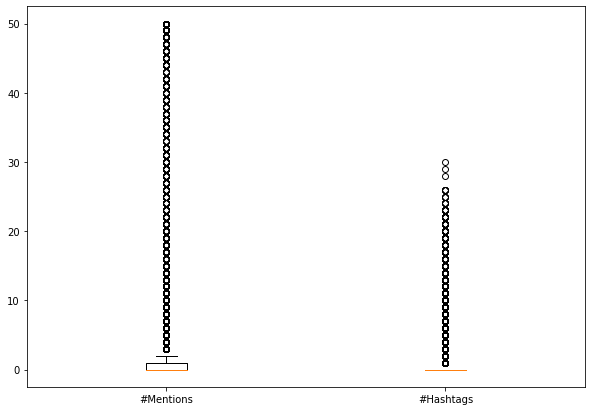

Tweet ID             0
#Followers           0
#Friends             0
#Retweets            0
#Favorites           0
Entities             0
Day                  0
Hour                 0
PositiveSentiment    0
NegativeSentiment    0
#Mentions            0
#Hashtags            0
dtype: int64

In [180]:
#1c - Fill in missing values in Mentions and Hashtags (Look at the dsitribution first)

plt.figure(figsize =(10, 7))
plt.boxplot(df[['#Mentions','#Hashtags']], labels = ['#Mentions','#Hashtags'])
plt.show()

df['#Mentions'].fillna(df['#Mentions'].median(), inplace = True)
df['#Hashtags'].fillna(df['#Hashtags'].median(), inplace = True)
df.isnull().sum()

#### Exploratory Data Analsis 

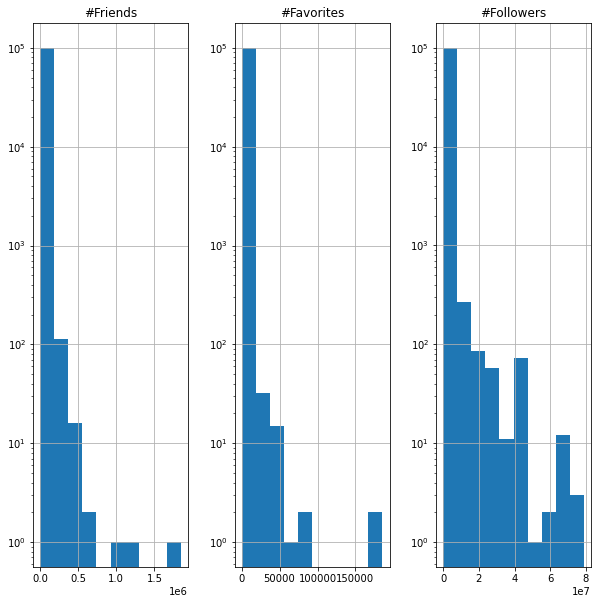

Tweet ID               int64
#Followers             int64
#Friends               int64
#Retweets              int64
#Favorites             int64
Entities               int64
Day                    int64
Hour                   int64
PositiveSentiment      int32
NegativeSentiment      int32
#Mentions            float64
#Hashtags            float64
dtype: object

In [181]:
#2a - visualize the columns number of friends, followers, favourites
fig, axes = plt.subplots(1, 3, figsize = (10,10))


df.hist('#Friends', ax=axes[0], log = True)
df.hist('#Favorites', ax=axes[1], log = True)
df.hist('#Followers', ax=axes[2], log = True)

plt.show()
df.dtypes

#### We can see that the highest number of friends, favourites and followers occur in the lower buckets of the histogram, there are more people with lesser number of friends, followers and favourites.

<AxesSubplot:>

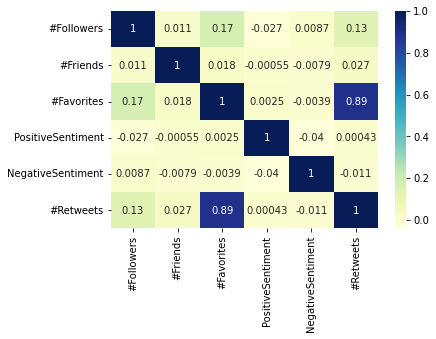

In [182]:
#2b - correlation matrix
sns.heatmap(df[['#Followers','#Friends','#Favorites','PositiveSentiment','NegativeSentiment','#Retweets']].corr(),annot = True, cmap="YlGnBu")


- We can see that the number of Retweets is highly correlated with the #Favourites. 
- There doesn't appear to be a high correlation between most of these variables.
- We can also see that the #Retweets is negatively correlated with Negative Sentiment
- Though the other variables show a very low correlation, it does not mean that they would not contribute to the model.
#### 2c) The plots and the correlation matrix show the trends in the data and the apparent relation between the target variables and independent variables.
####  2d) In general, positive correlation implies a positive effect on the variable we are observing and negative correlation implies a detrimental effect on the variable that we are observing.
####  2e) If a feature shows 0 correlation to Retweets, it does not mean that it could not contribute to a prediction. There might be non-linear relationship which the Pearson correlation ceofficient cannot capture. 

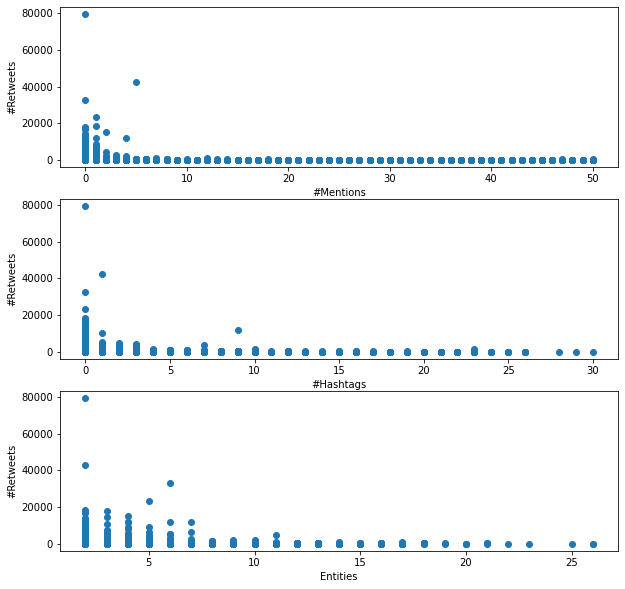

In [183]:
# check for any relationships between Retweets, #Mentions, #Hashtags, #Entities

fig, ax = plt.subplots(3, figsize=(10, 10))

ax[0].scatter(x = df['#Mentions'], y = df['#Retweets'])
ax[0].set_xlabel('#Mentions')
ax[0].set_ylabel('#Retweets')

ax[1].scatter(x = df['#Hashtags'], y = df['#Retweets'])
ax[1].set_xlabel('#Hashtags')
ax[1].set_ylabel('#Retweets')

ax[2].scatter(x = df['Entities'], y = df['#Retweets'])
ax[2].set_xlabel('Entities')
ax[2].set_ylabel('#Retweets')

plt.show()

 - We can see that, higher the number of retweets, lower the number of hashtags, mentions, entities.


### Build a Random Forest Regressor for the given data and evaluate

In [184]:
#split data into test and train
X = df.loc[:,df.columns !='#Retweets']
y = df['#Retweets']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)

#train and fit the model 
randomForestModel = RandomForestRegressor(n_estimators = 100, random_state = 42)

#fit model
randomForestModel.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [200]:
#predict on test 
y_pred = randomForestModel.predict(X_test)

#Calculate MSE and MAE 
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
MAE = metrics.mean_absolute_error(y_test, y_pred)
r2 =  metrics.r2_score(y_test, y_pred)


print("Mean Squared : {0}\nRoot Mean Squared Error : {1}\nMean Absolute Error: {2}\nR-squared : {3}".format(round(MSE,2),round(RMSE,2),round(MAE,2),round(r2,2)))

Mean Squared : 37936.92
Root Mean Squared Error : 194.77
Mean Absolute Error: 16.91
R-squared : 0.75


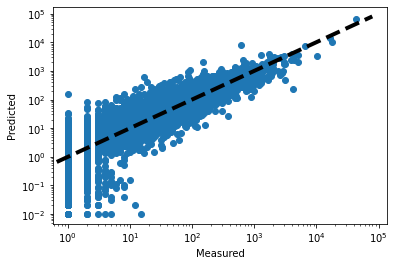

In [187]:
# visualize true and predicted 
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [188]:
#view the feature importances (in terms of Gini Index)
featureImportance = [(col, round(imp, 2)) for col, imp in zip(X.columns, list(randomForestModel.feature_importances_))]
sortedImportance = sorted(featureImportance, key = lambda x:x[1], reverse = True)
for i in range(len(sortedImportance)):
    print("Variable :{:20} Importance : {}".format(sortedImportance[i][0],sortedImportance[i][1]))

Variable :#Favorites           Importance : 0.88
Variable :Tweet ID             Importance : 0.04
Variable :#Followers           Importance : 0.02
Variable :#Friends             Importance : 0.02
Variable :Entities             Importance : 0.01
Variable :Day                  Importance : 0.01
Variable :Hour                 Importance : 0.01
Variable :NegativeSentiment    Importance : 0.01
Variable :#Mentions            Importance : 0.01
Variable :PositiveSentiment    Importance : 0.0
Variable :#Hashtags            Importance : 0.0


In [189]:
#search for best params using Hyperparameter tuning 

# Number of trees in random forest
n_estimators = [60,100,150]
# Maximum number of levels in tree
max_depth = [50,100]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
pprint(param_grid)

#Do randomized search
rfmodel = RandomForestRegressor()
searchModel = GridSearchCV(estimator = rfmodel,param_grid = param_grid, verbose = 2, cv = 3)
searchModel.fit(X_train, y_train)

{'max_depth': [50, 100], 'n_estimators': [60, 100, 150]}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ......................max_depth=50, n_estimators=60; total time=  17.7s
[CV] END ......................max_depth=50, n_estimators=60; total time=  16.2s
[CV] END ......................max_depth=50, n_estimators=60; total time=  17.3s
[CV] END .....................max_depth=50, n_estimators=100; total time=  29.0s
[CV] END .....................max_depth=50, n_estimators=100; total time=  28.2s
[CV] END .....................max_depth=50, n_estimators=100; total time=  35.6s
[CV] END .....................max_depth=50, n_estimators=150; total time=  45.6s
[CV] END .....................max_depth=50, n_estimators=150; total time=  41.4s
[CV] END .....................max_depth=50, n_estimators=150; total time=  44.3s
[CV] END .....................max_depth=100, n_estimators=60; total time=  16.9s
[CV] END .....................max_depth=100, n_estimators=60; total time=

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [50, 100],
                         'n_estimators': [60, 100, 150]},
             verbose=2)

In [215]:
pprint(searchModel.best_params_)


{'max_depth': 50, 'n_estimators': 150}


In [195]:
#test out model on the test set 
predicted = searchModel.predict(X_test)

#Calculate MSE and MAE 
MSE = metrics.mean_squared_error(y_test, predicted)
RMSE = np.sqrt(MSE)
MAE = metrics.mean_absolute_error(y_test, predicted)
r2 =  metrics.r2_score(y_test, predicted)

print("Mean Squared : {0}\nRoot Mean Squared Error : {1}\nMean Absolute Error: {2}\nR-squared : {3}".format(round(MSE,2),round(RMSE,2),round(MAE,2),round(r2,2)))

Mean Squared : 24205.22
Root Mean Squared Error : 155.58
Mean Absolute Error: 16.55
R-squared : 0.84


##### We can see that the R-squared value has increased from 0.75 to 0.82 and the Mean Squared Error has gone down to 27570 from 37936 upon Hyperparameter Tuning. Hence, we will retain this model and use the same for comparison.

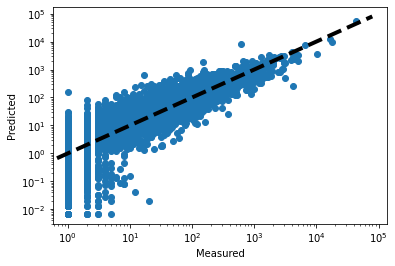

In [202]:
# visualize true and predicted 
fig, ax = plt.subplots()
ax.scatter(y_test, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

### Build a Ridge Regression Model for the same data and evaluate

In [197]:
#split data into test and train
X = df.loc[:,df.columns !='#Retweets']
y = df['#Retweets']

#split into test and train 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)

#standardize the train and test data (since we are using a regression technique)
scale = StandardScaler()
X_train_std = scale.fit_transform(X_train)
X_test_std = scale.transform(X_test)

In [198]:
#apply ridge regression includinng cross validation
cv = KFold(n_splits = 3, shuffle = True)
model = RidgeCV(alphas=[0.1, 1.0, 0], cv = cv)
model.fit(X_train_std, y_train)

RidgeCV(alphas=array([0.1, 1. , 0. ]),
        cv=KFold(n_splits=3, random_state=None, shuffle=True))

In [199]:
#predict on test 
y_pred = model.predict(X_test_std)

#Calculate MSE and MAE 
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
MAE = metrics.mean_absolute_error(y_test, y_pred)
r2 =  metrics.r2_score(y_test, y_pred)

print("Mean Squared Error : {0}\nRoot Mean Squared Error : {1}\nMean Absolute Error: {2}\nR-squared : {3}".format(round(MSE,2),round(RMSE,2),round(MAE,2),round(r2,2)))

Mean Squared : 24728.3
Root Mean Squared Error : 157.25
Mean Absolute Error: 20.17
R-squared : 0.84


In [221]:
# Columns and their weights 
pprint(sorted(list(zip(list(X.columns), model.coef_)), key = lambda x:x[1], reverse = True))

[('#Favorites', 366.96647436115927),
 ('#Friends', 4.444923524955024),
 ('Tweet ID', 3.857476987561711),
 ('Entities', 3.578382040783914),
 ('#Hashtags', 2.092010070354886),
 ('#Mentions', -0.20907502467887656),
 ('PositiveSentiment', -0.9729739400379097),
 ('Hour', -1.5194073770247425),
 ('NegativeSentiment', -2.4734699782469898),
 ('Day', -3.753401194138635),
 ('#Followers', -11.739595804062391)]


#### Feature Interpretation : 
- Though most of the features showed a very small correlation in the correlation table, we can see that most of them have a significant weight. However, the highest effect was from the Favourites feature.
- Followers shows a negative coefficient of -11 even though the correlation coefficient was a small positive number (0.13)

## Comparison of the two models : 

   - Though both the Random forest and the Ridge Regression model have the exact same R-squared score of 0.84, we can see that Random Forest Model has lower RMSE, MAE and MSE compared to Ridge Regression. 
   - The fit for both the models are good, as seen on the scatter plot. 
   - Based on the Random Forest model, the Followers, Tweet ID, Favourites are the top 3 significant variables. 
   - Based on the Ridge Regression Model, #Favourites, #Followers and TweetID are the most significantly weighted variables. 
   
#### Both models have a similar effect. However, the Random Forest model outperforms the Ridge Regression model by a small margin.